In [14]:
# 모듈 import
import numpy as np
import os, random
import random
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models, datasets, transforms

### 1. 이미지 데이터 불러오고 전처리

In [4]:
# 성능 재현을 위한 seed 고정
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.bencmark=False
    os.environ['PYTHONHASHSEED']=str(seed)
seed_everything(2024)

In [5]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
print(f'Using Pytorch version: {torch.__version__} DEVICE: {DEVICE}')

Using Pytorch version: 2.3.0 DEVICE: cpu


In [6]:
data_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

In [7]:
image_datasets = datasets.ImageFolder(root='../data/starbucks_top10', transform=data_transforms)
image_datasets.classes

['Cold_Brew_or_Iced_Caffe_Americano_or_Iced_Coffee',
 'Iced_Caffe_Latte_or_Dolce_Cold_Brew_or_Iced_Starbucks_Dolce_Latte',
 'Iced_Caramel_Macchiato',
 'Iced_Grapefruit_Honey_Black_Tea',
 'Iced_Malcha_Latte_from_Jeju_Organic_Farm',
 'Iced_Mango_Passion_Fruit_Blended',
 'Iced_Mint_Chocolate_Chip_Blended',
 'Iced_Strawberry_Delight_Yogurt_Blended',
 'Java_Chip_Frappuccino',
 'Vanila_Cream_Cold_Brew']

In [8]:
len(image_datasets)

2874

### 2. 이미지 데이터셋 split

In [9]:
train_size = int(0.4*len(image_datasets))
val_size = int(0.3*len(image_datasets))
test_size = len(image_datasets)-train_size-val_size

print(f'train size: {train_size}')
print(f'val_size: {val_size}')
print(f'test size: {test_size}')

train size: 1149
val_size: 862
test size: 863


In [11]:
BATCH_SIZE=64

# split to train, valid, test dataset
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(image_datasets, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(2024))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [12]:
# 데이터 확인
for(x_train, y_train) in train_loader:
    print(f'x_train: {x_train.size()} type: {x_train.type()}')
    print(f'y_train: {y_train.size()} type: {y_train.type()}')
    break

x_train: torch.Size([64, 3, 256, 256]) type: torch.FloatTensor
y_train: torch.Size([64]) type: torch.LongTensor


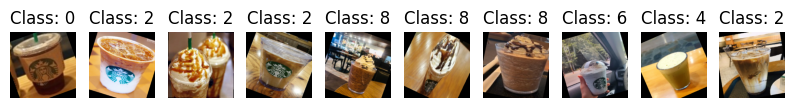

In [13]:
# 데이터 확인 (2)
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.axis('off')
    plt.imshow(np.transpose(x_train[i], (1, 2, 0)))
    plt.title(f'Class: {str(y_train[i].item())}')

### 3. 모델 설계

#### (1) 커스텀 모델 설계

In [15]:
class ResNet50CustomLayer(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet50CustomLayer, self).__init__()
        resnet = models.resnet50(weights="IMAGENET1K_V2")
        # layer 가중치 동결
        for param in resnet.parameters():
          param.requires_grad=False
        self.features = nn.Sequential(*list(resnet.children())[:-2])

        # insert layer
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(2048*4*4, 512)
        self.batch_norm1 = nn.BatchNorm1d(512)

        self.fc2 = nn.Linear(512, 256)
        self.batch_norm2 = nn.BatchNorm1d(256)

        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.maxpool(x)
        x = self.flatten(x)
        x = self.dropout(x)

        x = F.relu(self.fc1(x))
        x = self.batch_norm1(x)

        x = F.relu(self.fc2(x))
        x = self.batch_norm2(x)

        x = F.log_softmax(self.fc3(x), dim=1)
        return x

#### (2) 모델 훈련, 검증 함수 작성

In [1]:
from tqdm import tqdm

def train(model, train_loader, optimizer):
    model.train() # 학습 상태로 지정
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc="Training Progress")

    for batch_idx, (image, label) in progress_bar:
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad() #optimizer의 gradient 초기화
        output = model(image)
        loss = criterion(output, label)
        loss.backward() # Back Propagation을 통해 계산한 Gradient 파라미터에 할당
        optimizer.step()

        progress_bar.set_postfix(loss=loss.item())

def evaluate(model, test_loader):
    model.eval() # 평가상태로 지정
    test_loss=0 # Loss값 계산을 위해 0으로 임시 설정
    correct=0
    with torch.no_grad(): # Gradient값 업데이트 방지
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim=True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    test_loss /= len(test_loader.dataset)
    test_acc = 100. *correct / len(test_loader.dataset)
    return test_loss, test_acc

def train_model(model, EPOCHS, early_stop_epochs):
    best_loss = float('inf')
    early_stop_counter=0
    for Epoch in range(1, EPOCHS+1):
        train(model, train_loader, optimizer)
        test_loss, test_acc = evaluate(model, test_loader)
        print('\n[EPOCH: {}], \tTest Accuracy: {:.2f}%, \tTest Loss: {:.4f}'.format(Epoch, test_acc, test_loss))

        if test_loss > best_loss:
            early_stop_counter+=1
            if early_stop_counter>=early_stop_epochs:
                print('Early Stopping!!')
                break
            else:
                best_loss=test_loss
                early_stop_counter=0
                torch.save({
                    'epoch':Epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'accuracy': test_acc,
                    'loss': test_loss
                }, '../saved/model_{:.2f}_epoch{}.pt'.format(test_acc, Epoch))
                print('Clear to save checkpoint model: model_{:.2f}_epoch{}.pt \n'.format(test_acc, Epoch))

### 4. 모델 훈련 및 성능 검증

#### (1) 모델 훈련

In [17]:
model = ResNet50CustomLayer().to(DEVICE)

# model compile
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = nn.CrossEntropyLoss()

train_model(model, EPOCHS=30, early_stop_epochs=5)

Training Progress: 100%|██████████| 18/18 [05:28<00:00, 18.26s/it, loss=1.02] 



[EPOCH: 1], 	Test Accuracy: 61.30%, 	Test Loss: 0.0205


Training Progress: 100%|██████████| 18/18 [05:28<00:00, 18.25s/it, loss=0.597]



[EPOCH: 2], 	Test Accuracy: 79.61%, 	Test Loss: 0.0093


Training Progress:  94%|█████████▍| 17/18 [05:26<00:19, 19.19s/it, loss=0.437]


KeyboardInterrupt: 

#### (2) 모델 성능 검증 (valid dataset 이용)

In [18]:
model = ResNet50CustomLayer()
checkpoint=torch.load('../saved/model_9_80.30.pt', map_location=torch.device('cpu'))
model.load_state_dict(checkpoint.get('model_state_dict'))

test_loss, test_acc = evaluate(model, val_loader)
print('Test Accuracy: {:.2f}% \t Test Loss: {:.4f}'.format(test_acc, test_loss))

Test Accuracy: 79.47% 	 Test Loss: 0.0105
